In [1]:
import h5py
import numpy as np
import scipy.stats
import scipy.ndimage
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import tqdm
tqdm.tqdm_notebook()

|<bar/>| 0/? [00:00<?, ?it/s]

### Define constants and paths

In [2]:
tf_names = ["E2F6", "FOXA2", "SPI1", "CEBPB", "MAX", "NR3C1", "GABPA"]
folds = {
    "E2F6": 9,
    "FOXA2": 6,
    "SPI1": 7,
    "CEBPB": 6,
    "MAX": 10,
    "NR3C1": 6,
    "GABPA": 10,
    "MAFK": 6,
    "JUND": 6,
    "REST": 6
}
predictions_paths = {
    tf_name: "/users/amtseng/tfmodisco/results/peak_predictions/{0}/{0}_peak_prediction_performance.h5".format(tf_name)
    for tf_name in tf_names
}
performance_bounds_paths = {
    tf_name: "/users/amtseng/tfmodisco/results/performance_bounds/{0}/{0}_performance_bounds.h5".format(tf_name)
    for tf_name in tf_names
}

In [3]:
input_length = 1346
profile_length = 1000

### Import the set of performance metrics
For each peak, get the actual performance metrics, the lower bounds, and the upper bounds. The coordinates in the files should match exactly\*

\*The saved coordinates in the predictions/actual performances are padded to the input length, but the coordinates in the performance bounds are padded to the profile length

In [4]:
def import_metrics():
    """
    For each TF, imports the set of all metrics. Returns a dictionary of the following
    format:
        `tf_1`:
            `actual_perf`:
                `nll`: ...
                `norm_nll`: ...
                ...
            `lower_perf`:
                ...
            `upper_perf`:
                ...
        `tf_2`:
        ...
    """
    all_perfs = {}
    for tf_name in tqdm.notebook.tqdm(tf_names):
        fold = folds[tf_name]
        predictions_path = predictions_paths[tf_name]
        performance_bounds_path = performance_bounds_paths[tf_name]
        
        pred_reader = h5py.File(predictions_path, "r")
        perf_bound_reader = h5py.File(performance_bounds_path, "r")
        
        pred_reader_coords = pred_reader["fold%d" % fold]["coords"]
        perf_bound_reader_coords = perf_bound_reader["coords"]
        
        # Assert that the coordinates are the same in both files, once the proper padding is added
        assert np.all(
            pred_reader_coords["coords_end"][:] - pred_reader_coords["coords_start"][:] == input_length
        )
        assert np.all(
            perf_bound_reader_coords["coords_end"][:] - perf_bound_reader_coords["coords_start"][:] ==
            profile_length
        )
        assert np.all(
            perf_bound_reader_coords["coords_start"][:] - ((input_length - profile_length) // 2) ==
            pred_reader_coords["coords_start"][:]
        )
        assert np.all(
            perf_bound_reader_coords["coords_end"][:] + ((input_length - profile_length) // 2) ==
            pred_reader_coords["coords_end"][:]
        )
        assert np.all(
            perf_bound_reader_coords["coords_chrom"][:] == pred_reader_coords["coords_chrom"][:]
        )
        
        actual_perf = pred_reader["fold%d" % fold]["performance"]
        lower_perf = perf_bound_reader["performance_lower"]
        upper_perf = perf_bound_reader["performance_upper"]
        actual_perf_dict = {key : actual_perf[key][:] for key in actual_perf.keys()}
        lower_perf_dict = {key : lower_perf[key][:] for key in lower_perf.keys()}
        upper_perf_dict = {key : upper_perf[key][:] for key in upper_perf.keys()}
        
        # Compute the normalized NLL for the actual performance 
        actual_perf_dict["norm_nll"] = actual_perf_dict["nll"] / \
            np.mean(np.sum(pred_reader["fold%d" % fold]["predictions"]["true_profs"][:], axis=2), axis=2)
        
        all_perfs[tf_name] = {
            "actual_perf": actual_perf_dict,
            "lower_perf": lower_perf_dict,
            "upper_perf": upper_perf_dict
        }
        
        pred_reader.close()
        perf_bound_reader.close()
    return all_perfs

In [5]:
all_perfs = import_metrics()

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


### Plot the performance bounds

In [6]:
def plot_bounds(metric_key, metric_name):
    plt.figure(figsize=(20, 4))
    lower_bound = [np.nanmean(all_perfs[tf_name]["lower_perf"][metric_key]) for tf_name in tf_names]
    actual_val = [np.nanmean(all_perfs[tf_name]["actual_perf"][metric_key]) for tf_name in tf_names]
    upper_bound = [np.nanmean(all_perfs[tf_name]["upper_perf"][metric_key]) for tf_name in tf_names]

    label_locs = np.arange(len(tf_names))  # Location of labels
    width = 0.25  # Width of bars

    plt.bar(label_locs - width, lower_bound, width, label="Randomized profiles")
    plt.bar(label_locs, actual_val, width, label="Model predictions")
    plt.bar(label_locs + width, upper_bound, width, label="Experimental replicates")

    plt.title("Mean %s of each TF" % metric_name)
    plt.xticks(label_locs, labels=tf_names)
    plt.legend()

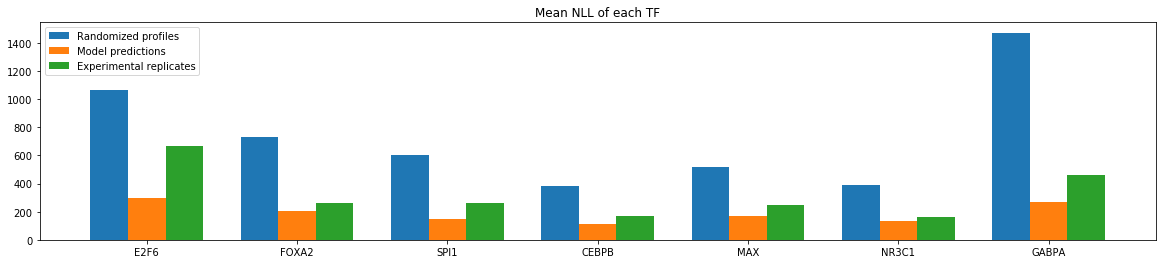

In [11]:
plot_bounds("nll", "NLL")

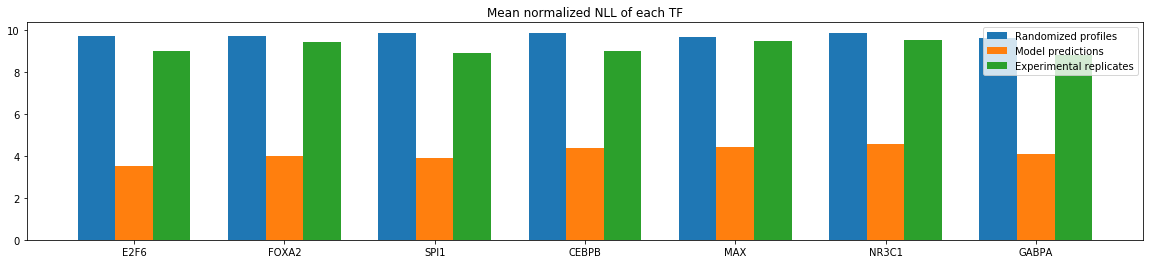

In [12]:
plot_bounds("norm_nll", "normalized NLL")

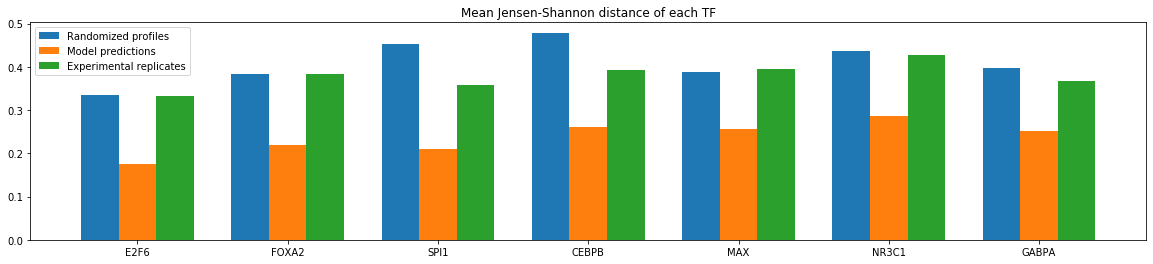

In [13]:
plot_bounds("jsd", "Jensen-Shannon distance")

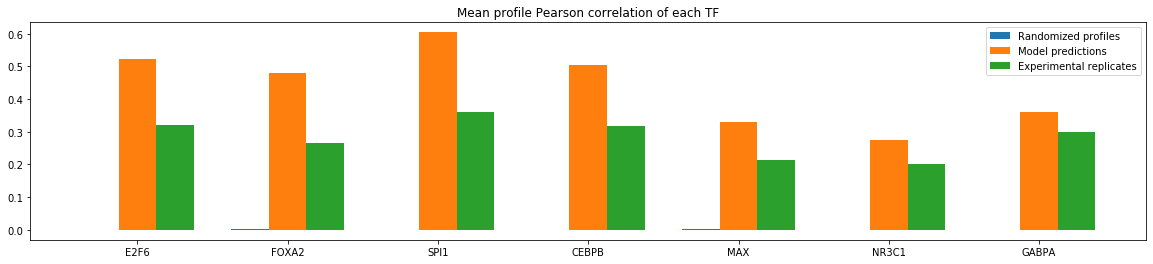

In [14]:
plot_bounds("profile_pearson", "profile Pearson correlation")

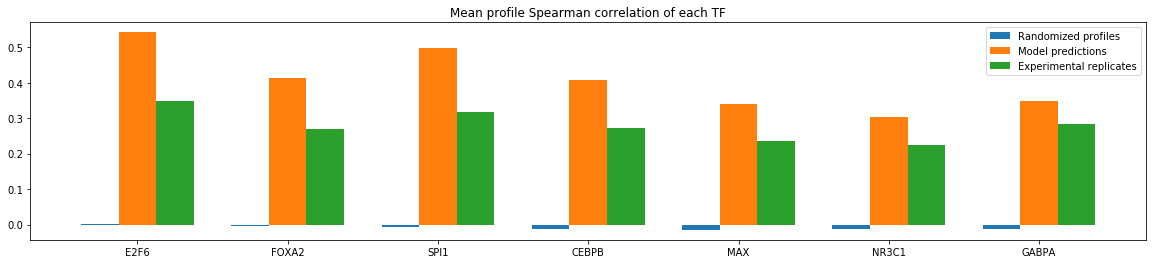

In [15]:
plot_bounds("profile_spearman", "profile Spearman correlation")

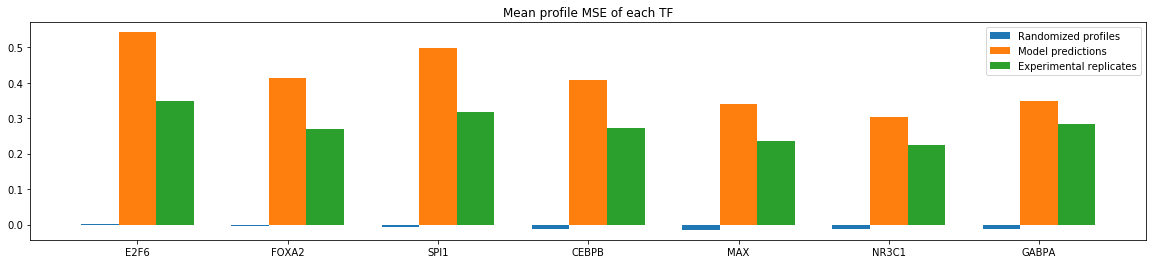

In [16]:
plot_bounds("profile_spearman", "profile MSE")

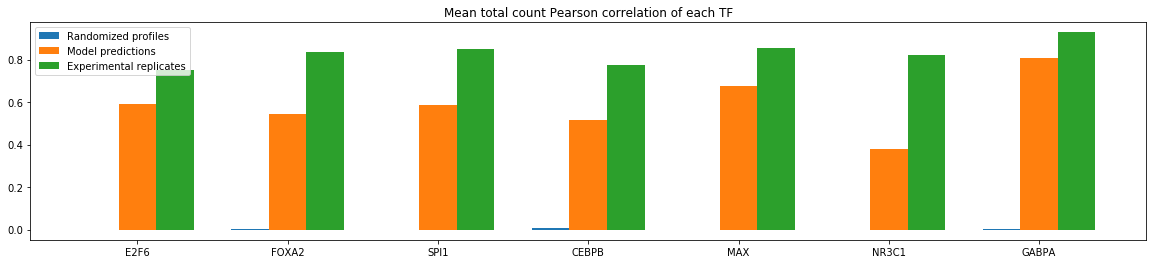

In [17]:
plot_bounds("count_pearson", "total count Pearson correlation")

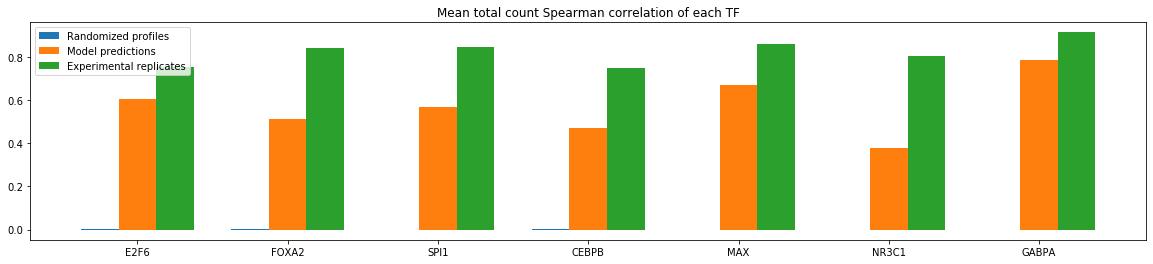

In [18]:
plot_bounds("count_spearman", "total count Spearman correlation")

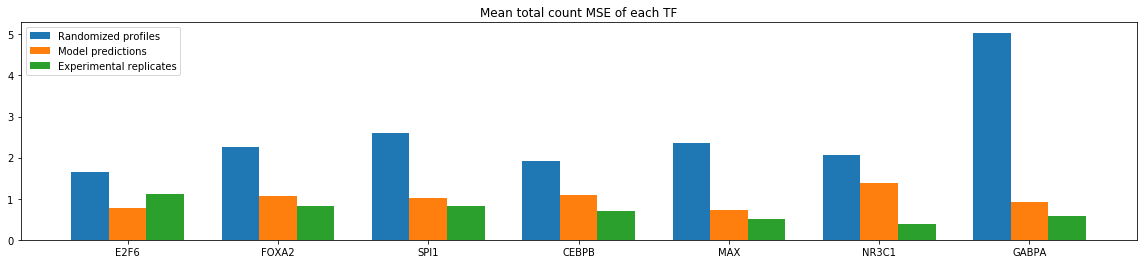

In [19]:
plot_bounds("count_mse", "total count MSE")

In [20]:
predictions_path = predictions_paths["SPI1"]
performance_bounds_path = performance_bounds_paths["SPI1"]
replicate_profs_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/labels/SPI1/SPI1_replicate_profiles.h5"
fold = folds["SPI1"]

pred_reader = h5py.File(predictions_path, "r")
perf_bound_reader = h5py.File(performance_bounds_path, "r")
replicate_profs_reader = h5py.File(replicate_profs_path, "r")

In [21]:
def plot_coord(coord_index):
    chrom = perf_bound_reader["coords"]["coords_chrom"][coord_index].decode()
    start = perf_bound_reader["coords"]["coords_start"][coord_index]
    end = perf_bound_reader["coords"]["coords_end"][coord_index]
    print(chrom, start, end)
    
    replicates = replicate_profs_reader[chrom][start:end]
    num_tasks = replicates.shape[1]
    
    def smooth(track, axis=-1):
        return scipy.ndimage.gaussian_filter1d(                         
            track, 7, axis=axis, truncate=((81 - 1) / (2 * 7))
        )
    
    replicates_smooth = smooth(replicates, axis=0)
    
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(replicates[:,i,0,0], color="royalblue", alpha=0.5)
        ax[i].plot(-replicates[:,i,0,1], color="goldenrod", alpha=0.5)
        ax[i].plot(replicates[:,i,1,0], color="darkslateblue")
        ax[i].plot(-replicates[:,i,1,1], color="darkorange")
    plt.show()
    
    true_profs = pred_reader["fold%d" % fold]["predictions"]["true_profs"][coord_index]
    pred_profs = np.exp(pred_reader["fold%d" % fold]["predictions"]["log_pred_profs"][coord_index])
    true_profs = true_profs / np.sum(true_profs, axis=1, keepdims=True)
    pred_profs = pred_profs / np.sum(pred_profs, axis=1, keepdims=True)
    true_profs_smooth = smooth(true_profs, axis=1)
    pred_profs_smooth = smooth(pred_profs, axis=1)
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    plt.show()
    
    for i in range(num_tasks):
        print(scipy.stats.pearsonr(np.ravel(replicates_smooth[:,i,0]), np.ravel(replicates_smooth[:,i,1]))[0])
    print(perf_bound_reader["performance_upper"]["profile_pearson"][coord_index])
        
    for i in range(num_tasks):
        print(scipy.stats.pearsonr(np.ravel(true_profs_smooth[i]), np.ravel(pred_profs_smooth[i]))[0])
    print(pred_reader["fold%d" % fold]["performance"]["profile_pearson"][coord_index])

chr14 80941021 80942021


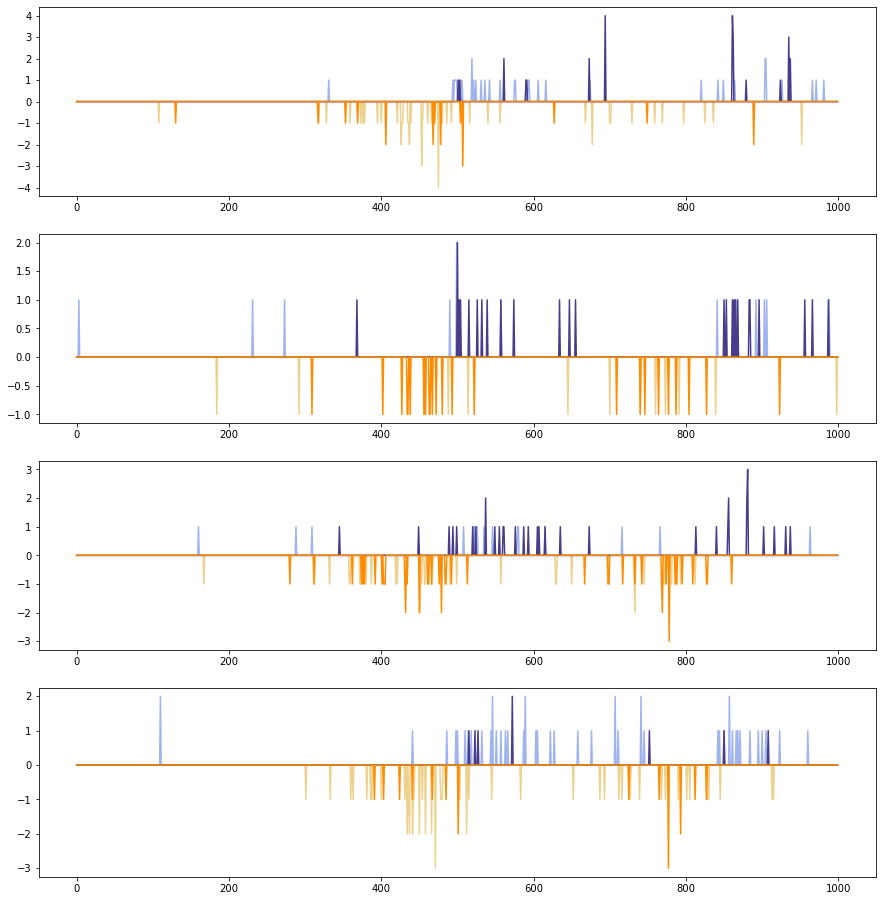

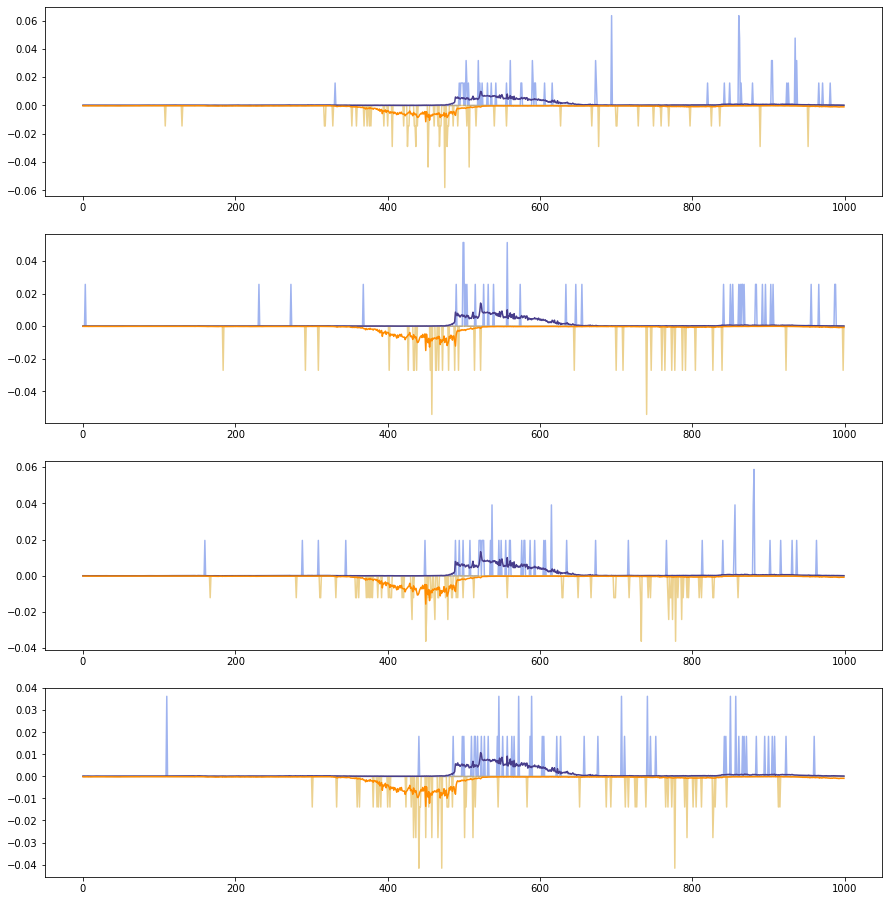

0.26695356356711436
0.41263567615027025
0.5479829794409514
0.43640596168603757
[0.28879329 0.40931602 0.44246589 0.41555428]
0.7331759976436223
0.5657132299482683
0.7488834003482807
0.7455391904477328
[0.73317602 0.5657132  0.74888342 0.74553919]


In [23]:
plot_coord(1000)